In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
from pathlib import Path

In [24]:
def v_fit(drifts, vmeans):
    ## Calibration parameters: y_measured = p0*x_true + p1 => true = (measured - p1)*1/p0
    p = np.polyfit(drifts, vmeans, 1)
    vxfits = p[0] * drifts + p[1]
    a_v = 1 / p[0]
    vxfits2 = (vmeans - p[1]) * a_v
    # Calculate residuals
    residuals = np.abs(vxfits - vmeans)
    residuals2 = np.abs(vxfits2 - drifts)
    return vxfits, residuals, vxfits2, residuals2

In [3]:
def read_vx(file, data_str):
    idl_dict = readsav(file)
    vx = idl_dict[data_str]
    return vx

dv = 0.04
drifts = np.arange(-0.2, 0.21, dv)

In [4]:
datadir = os.path.expanduser('~/Data/Karin/sanity_check')
lctfiles0 = list(Path(os.path.join(datadir, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save'))
lctfiles1 = list(Path(os.path.join(datadir, 'flct-tests-skip/Stein-simulation-2skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles2 = list(Path(os.path.join(datadir, 'flct-tests-skip/Stein-simulation-3skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles0.sort()
lctfiles1.sort()
lctfiles2.sort()
lctfiles = [lctfiles0, lctfiles1, lctfiles2]
# for filelist in lctfiles:
#     for f in filelist:
#         print(f)

In [5]:
vxs = [[read_vx(file, 'vx') for file in lctfiles_skip] for lctfiles_skip in lctfiles]

In [6]:
pad = 10
vxs2 = [[vx[0:27, pad:-pad, pad:-pad].mean()/(i+1) for vx in vxs_skip] for i, vxs_skip in enumerate(vxs)]

In [26]:
vxfits = []
residuals = []
vxfits2 = []
residuals2 = []
for vxmeans in vxs2:
    fit, res, fit2, res2 = v_fit(drifts, vxmeans)
    vxfits.append(fit)
    residuals.append(res)
    vxfits2.append(fit2)
    residuals2.append(res2)

## Shifts between two different images spaced  by different time gaps,  scale = 15 px

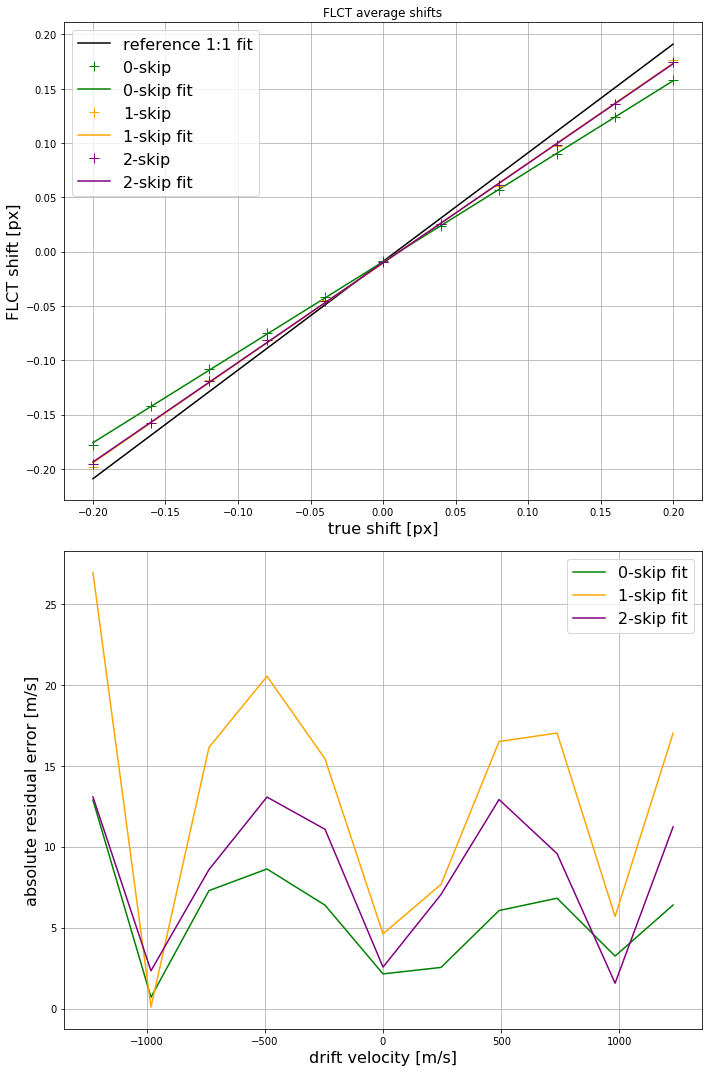

In [32]:
u = 368000 / 60
%matplotlib inline
fs = 16
colors = ['green', 'orange', 'purple']
fig, ax = plt.subplots(2,1, figsize = (10,15))
ax[0].plot(drifts, drifts + vxs2[0][5], 'k-', label='reference 1:1 fit')
for i in range(3):
    ax[0].plot(drifts, vxs2[i], marker='+', ms=10, ls='none', color=colors[i], label = '{:d}-skip'.format(i))
    ax[0].plot(drifts, vxfits[i], ls='-', color=colors[i], label = '{:d}-skip fit'.format(i))
ax[0].grid(True, axis='both')
ax[0].set_xlabel('true shift [px]', fontsize=fs)
ax[0].set_ylabel('FLCT shift [px]', fontsize=fs)
# plt.xlim([0, 2])
# plt.ylim([0, 2])
ax[0].legend(fontsize=fs)
ax[0].set_title('FLCT average shifts')

for i in range(3):
    ax[1].plot(drifts*u, residuals2[i]*u, color=colors[i], label = '{:d}-skip fit'.format(i))

ax[1].set_xlabel('drift velocity [m/s]', fontsize=fs)
ax[1].set_ylabel('absolute residual error [m/s]', fontsize=fs)
ax[1].grid(True, axis='both')
ax[1].legend(fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(datadir, 'flct_sanity_check_on_drifts.png'), dpi=300)


### Load Stein MHD simulation velocity and get correlation with FLCT

In [42]:
import fitsio
from scipy.signal import convolve2d

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson



In [43]:
data_dir_stein = os.path.expanduser('~/Data/Ben/SteinSDO/')
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
trange = [0,29]
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)


# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fwhm = 7
fov = np.s_[pad:imsize - pad, pad:imsize-pad]
# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein[fov].mean()
print(vx_stein_mean, 'm/s')

# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='boxcar') 

-90.40378 m/s


#### Get FLCT at zero drift

In [45]:
lct_vels = [[vx/(i+1) for vx in vxs_skip[5]] for i, vxs_skip in enumerate(vxs)]

In [ ]:
c_pearsons = [calc_c_pearson(vx_stein_sm, vx_flct, vy_stein_sm, vy_flct, fov=fov)
print(c_pearsons)